<a href="https://colab.research.google.com/github/Mulingedzi/data_science-assignment/blob/main/FRAUD_DETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import files
import pandas as pd
import io

# Upload your files
uploaded = files.upload()

# Load the datasets
for filename in uploaded.keys():
  fraud_df = pd.read_csv(io.BytesIO(uploaded[filename]))


print("Dataset loaded successfully!")
print("Question 2 shape:", fraud_df.shape)

Saving Question 2 Datasets .csv to Question 2 Datasets  (4).csv
Dataset loaded successfully!
Question 2 shape: (200, 6)


In [5]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [8]:
# Separate labeled and unlabeled data
labeled_data = fraud_df[fraud_df['Is_Fraud (Labeled Subset)'] != -1]
unlabeled_data = fraud_df[fraud_df['Is_Fraud (Labeled Subset)'] == -1]

print(f"Labeled data: {len(labeled_data)} records")
print(f"Unlabeled data: {len(unlabeled_data)} records")

Labeled data: 100 records
Unlabeled data: 100 records


In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Amount', 'Time_Hour']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Location', 'Merchant'])
    ])

In [10]:
X_cluster = unlabeled_data.drop(['Index', 'Is_Fraud (Labeled Subset)'], axis=1)
X_processed = preprocessor.fit_transform(X_cluster)


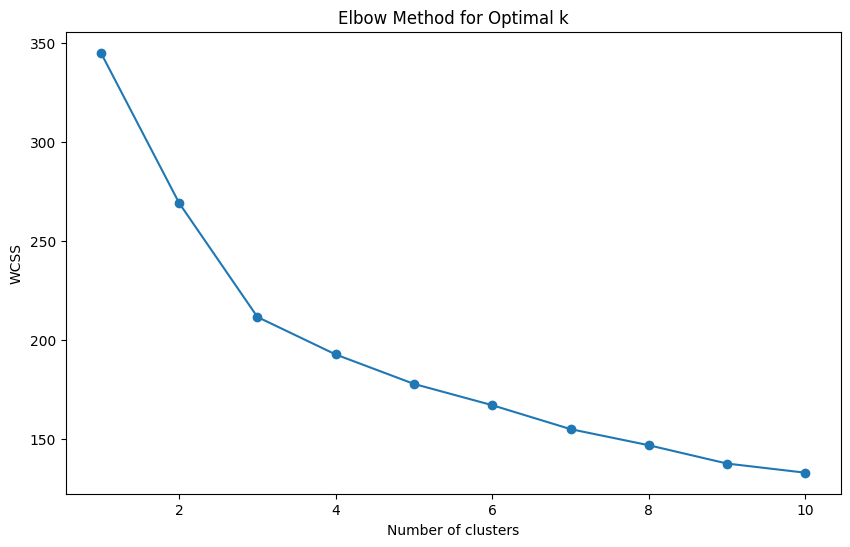

In [11]:
# Elbow method to find optimal k
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X_processed)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('elbow_method.png')
plt.show()

In [12]:
# Apply K-Means with optimal k (let's say k=3 based on elbow)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_processed)

# Add clusters to dataframe
unlabeled_data['Cluster'] = clusters

# Analyze clusters for anomalies
cluster_stats = unlabeled_data.groupby('Cluster').agg({
    'Amount': ['mean', 'std', 'count'],
    'Time_Hour': ['mean', 'std']
}).round(2)

print("\nCluster Statistics:")
print(cluster_stats)
# Identify potential fraud clusters (high amount, unusual times)
potential_fraud_clusters = unlabeled_data[
    (unlabeled_data['Amount'] > unlabeled_data['Amount'].mean() + 2 * unlabeled_data['Amount'].std()) |
    (unlabeled_data['Time_Hour'].isin([0, 1, 2, 3, 22, 23]))  # Late night/early morning
]

print(f"\nPotential fraud transactions identified: {len(potential_fraud_clusters)}")



Cluster Statistics:
          Amount               Time_Hour      
            mean     std count      mean   std
Cluster                                       
0        1223.14  455.80    28      4.46  3.20
1         339.07  294.32    37     14.35  4.98
2        1523.28  356.52    35     17.23  3.43

Potential fraud transactions identified: 18


/tmp/ipython-input-1238620809.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unlabeled_data['Cluster'] = clusters


In [13]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Prepare labeled data for classification
X_labeled = labeled_data.drop(['Index', 'Is_Fraud (Labeled Subset)'], axis=1)
y_labeled = labeled_data['Is_Fraud (Labeled Subset)']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Amount', 'Time_Hour']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Location', 'Merchant'])
    ])

# Split labeled data
X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.3, random_state=42)

# Create and train Naïve Bayes model
nb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])

nb_pipeline.fit(X_train, y_train)

# Predictions
y_pred = nb_pipeline.predict(X_test)

# Evaluation
print("Naïve Bayes Classification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

Naïve Bayes Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.79      0.85        28
         1.0       0.00      0.00      0.00         2

    accuracy                           0.73        30
   macro avg       0.46      0.39      0.42        30
weighted avg       0.86      0.73      0.79        30


Confusion Matrix:
[[22  6]
 [ 2  0]]
F1 Score: 0.0000


In [14]:
def engineer_features(df):
    df = df.copy()

    # Time categories
    df['Time_Category'] = pd.cut(df['Time_Hour'],
                                bins=[-1, 6, 12, 18, 24],
                                labels=['Night', 'Morning', 'Afternoon', 'Evening'])

    # Amount categories
    df['Amount_Category'] = pd.qcut(df['Amount'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

    # Transaction size relative to average
    df['Amount_Ratio'] = df['Amount'] / df['Amount'].mean()

    # Weekend vs weekday (if you had date information)
    # df['Is_Weekend'] = df['Transaction_Date'].dt.dayofweek >= 5

    return df

# Apply feature engineering
X_labeled_eng = engineer_features(X_labeled)
X_train_eng, X_test_eng, y_train, y_test = train_test_split(X_labeled_eng, y_labeled, test_size=0.3, random_state=42)

# Update preprocessor for new features
preprocessor_eng = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Amount', 'Time_Hour', 'Amount_Ratio']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Location', 'Merchant', 'Time_Category', 'Amount_Category'])
    ])

# Retrain with engineered features
nb_pipeline_eng = Pipeline([
    ('preprocessor', preprocessor_eng),
    ('classifier', GaussianNB())
])

nb_pipeline_eng.fit(X_train_eng, y_train)
y_pred_eng = nb_pipeline_eng.predict(X_test_eng)

print("With Engineered Features:")
print(classification_report(y_test, y_pred_eng))
f1_eng = f1_score(y_test, y_pred_eng)
print(f"F1 Score with engineered features: {f1_eng:.4f}")

With Engineered Features:
              precision    recall  f1-score   support

         0.0       0.92      0.82      0.87        28
         1.0       0.00      0.00      0.00         2

    accuracy                           0.77        30
   macro avg       0.46      0.41      0.43        30
weighted avg       0.86      0.77      0.81        30

F1 Score with engineered features: 0.0000


In [15]:
from sklearn.model_selection import cross_val_score

# Cross-validation
cv_scores = cross_val_score(nb_pipeline_eng, X_labeled_eng, y_labeled, cv=10, scoring='f1')
print(f"Cross-validated F1 scores: {cv_scores}")
print(f"Mean F1 score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Compare supervised vs unsupervised approaches
print("\nComparison:")
print(f"Supervised (Naïve Bayes) F1 Score: {f1_eng:.4f}")
print(f"Unsupervised clustering identified {len(potential_fraud_clusters)} potential fraud transactions")

Cross-validated F1 scores: [0.         0.         0.         0.         0.         0.5
 0.66666667 0.66666667 0.         0.66666667]
Mean F1 score: 0.2500 (+/- 0.6191)

Comparison:
Supervised (Naïve Bayes) F1 Score: 0.0000
Unsupervised clustering identified 18 potential fraud transactions


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(
